<a href="https://colab.research.google.com/github/w1767/w1767/blob/main/ARIMA_LSTM_RL%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch
import tensorflow
import keras
import sklearn
from pathlib import Path
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
from arch import arch_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import os
import glob
import csv
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/PhD research/VIX daily.csv"

In [4]:
df=pd.read_csv("/content/drive/MyDrive/PhD research/VIX daily.csv")
             #  parse_dates=["Date"],
             #  index_col=["Date"]) # parse the date column and tell pandas that column 1 is a datetime)

In [5]:
#path = "/content/drive/MyDrive/PhD research/VIX daily.xlsx"

In [6]:
df.head()

,Date,Last Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,20/04/2022,21.19,NaN,NaN,NaN,NaN,NaN,NaN
1,19/04/2022,21.37,NaN,NaN,NaN,NaN,NaN,NaN
2,18/04/2022,22.17,NaN,NaN,NaN,NaN,NaN,NaN
3,14/04/2022,22.70,NaN,NaN,NaN,NaN,NaN,NaN
4,13/04/2022,21.82,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.isnull().any()

Date          True
Last Price    True
Unnamed: 2    True
Unnamed: 3    True
Unnamed: 4    True
Unnamed: 5    True
Unnamed: 6    True
Unnamed: 7    True
dtype: bool

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12247 entries, 0 to 12246
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        8136 non-null   object 
 1   Last Price  8136 non-null   float64
 2   Unnamed: 2  0 non-null      float64
 3   Unnamed: 3  0 non-null      float64
 4   Unnamed: 4  0 non-null      float64
 5   Unnamed: 5  0 non-null      float64
 6   Unnamed: 6  0 non-null      float64
 7   Unnamed: 7  0 non-null      float64
dtypes: float64(7), object(1)
memory usage: 765.6+ KB


In [9]:
len(df)

12247

In [10]:
VIX_daily = df[['Date', "Last Price"]]

In [11]:
VIX_daily

,Date,Last Price
0,20/04/2022,21.19
1,19/04/2022,21.37
2,18/04/2022,22.17
3,14/04/2022,22.70
4,13/04/2022,21.82
...,...,...
12242,NaN,NaN
12243,NaN,NaN
12244,NaN,NaN
12245,NaN,NaN


In [12]:
VIX_daily.isnull().any()

Date          True
Last Price    True
dtype: bool

In [13]:
VIX_daily=VIX_daily.dropna()

In [14]:
VIX_daily

,Date,Last Price
0,20/04/2022,21.19
1,19/04/2022,21.37
2,18/04/2022,22.17
3,14/04/2022,22.70
4,13/04/2022,21.82
...,...,...
8131,08/01/1990,20.26
8132,05/01/1990,20.11
8133,04/01/1990,19.22
8134,03/01/1990,18.19


In [15]:
df.index

RangeIndex(start=0, stop=12247, step=1)

In [16]:
## Checkning the business day's 

from pandas.tseries.offsets import BDay

isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(df.index).map(isBusinessDay)
match_series

Index([True, True, True, True, True, True, True, True, True, True,
       ...
       True, True, True, True, True, True, True, True, True, True],
      dtype='object', length=12247)

In [17]:
#VIX_daily['Date'] = (VIX_daily['Date'].apply(lambda x: float(x[0].replace(',', ''))))

In [18]:
df.dropna()

,Date,Last Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7


In [19]:
df['Date'] = pd.to_datetime(VIX_daily['Date'], errors='coerce', utc= True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12247 entries, 0 to 12246
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Date        8136 non-null   datetime64[ns, UTC]
 1   Last Price  8136 non-null   float64            
 2   Unnamed: 2  0 non-null      float64            
 3   Unnamed: 3  0 non-null      float64            
 4   Unnamed: 4  0 non-null      float64            
 5   Unnamed: 5  0 non-null      float64            
 6   Unnamed: 6  0 non-null      float64            
 7   Unnamed: 7  0 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 765.6 KB


In [21]:
df['Date'].dt.dayofweek.nunique()

7

In [22]:
VIX_daily.shape

(8136, 2)

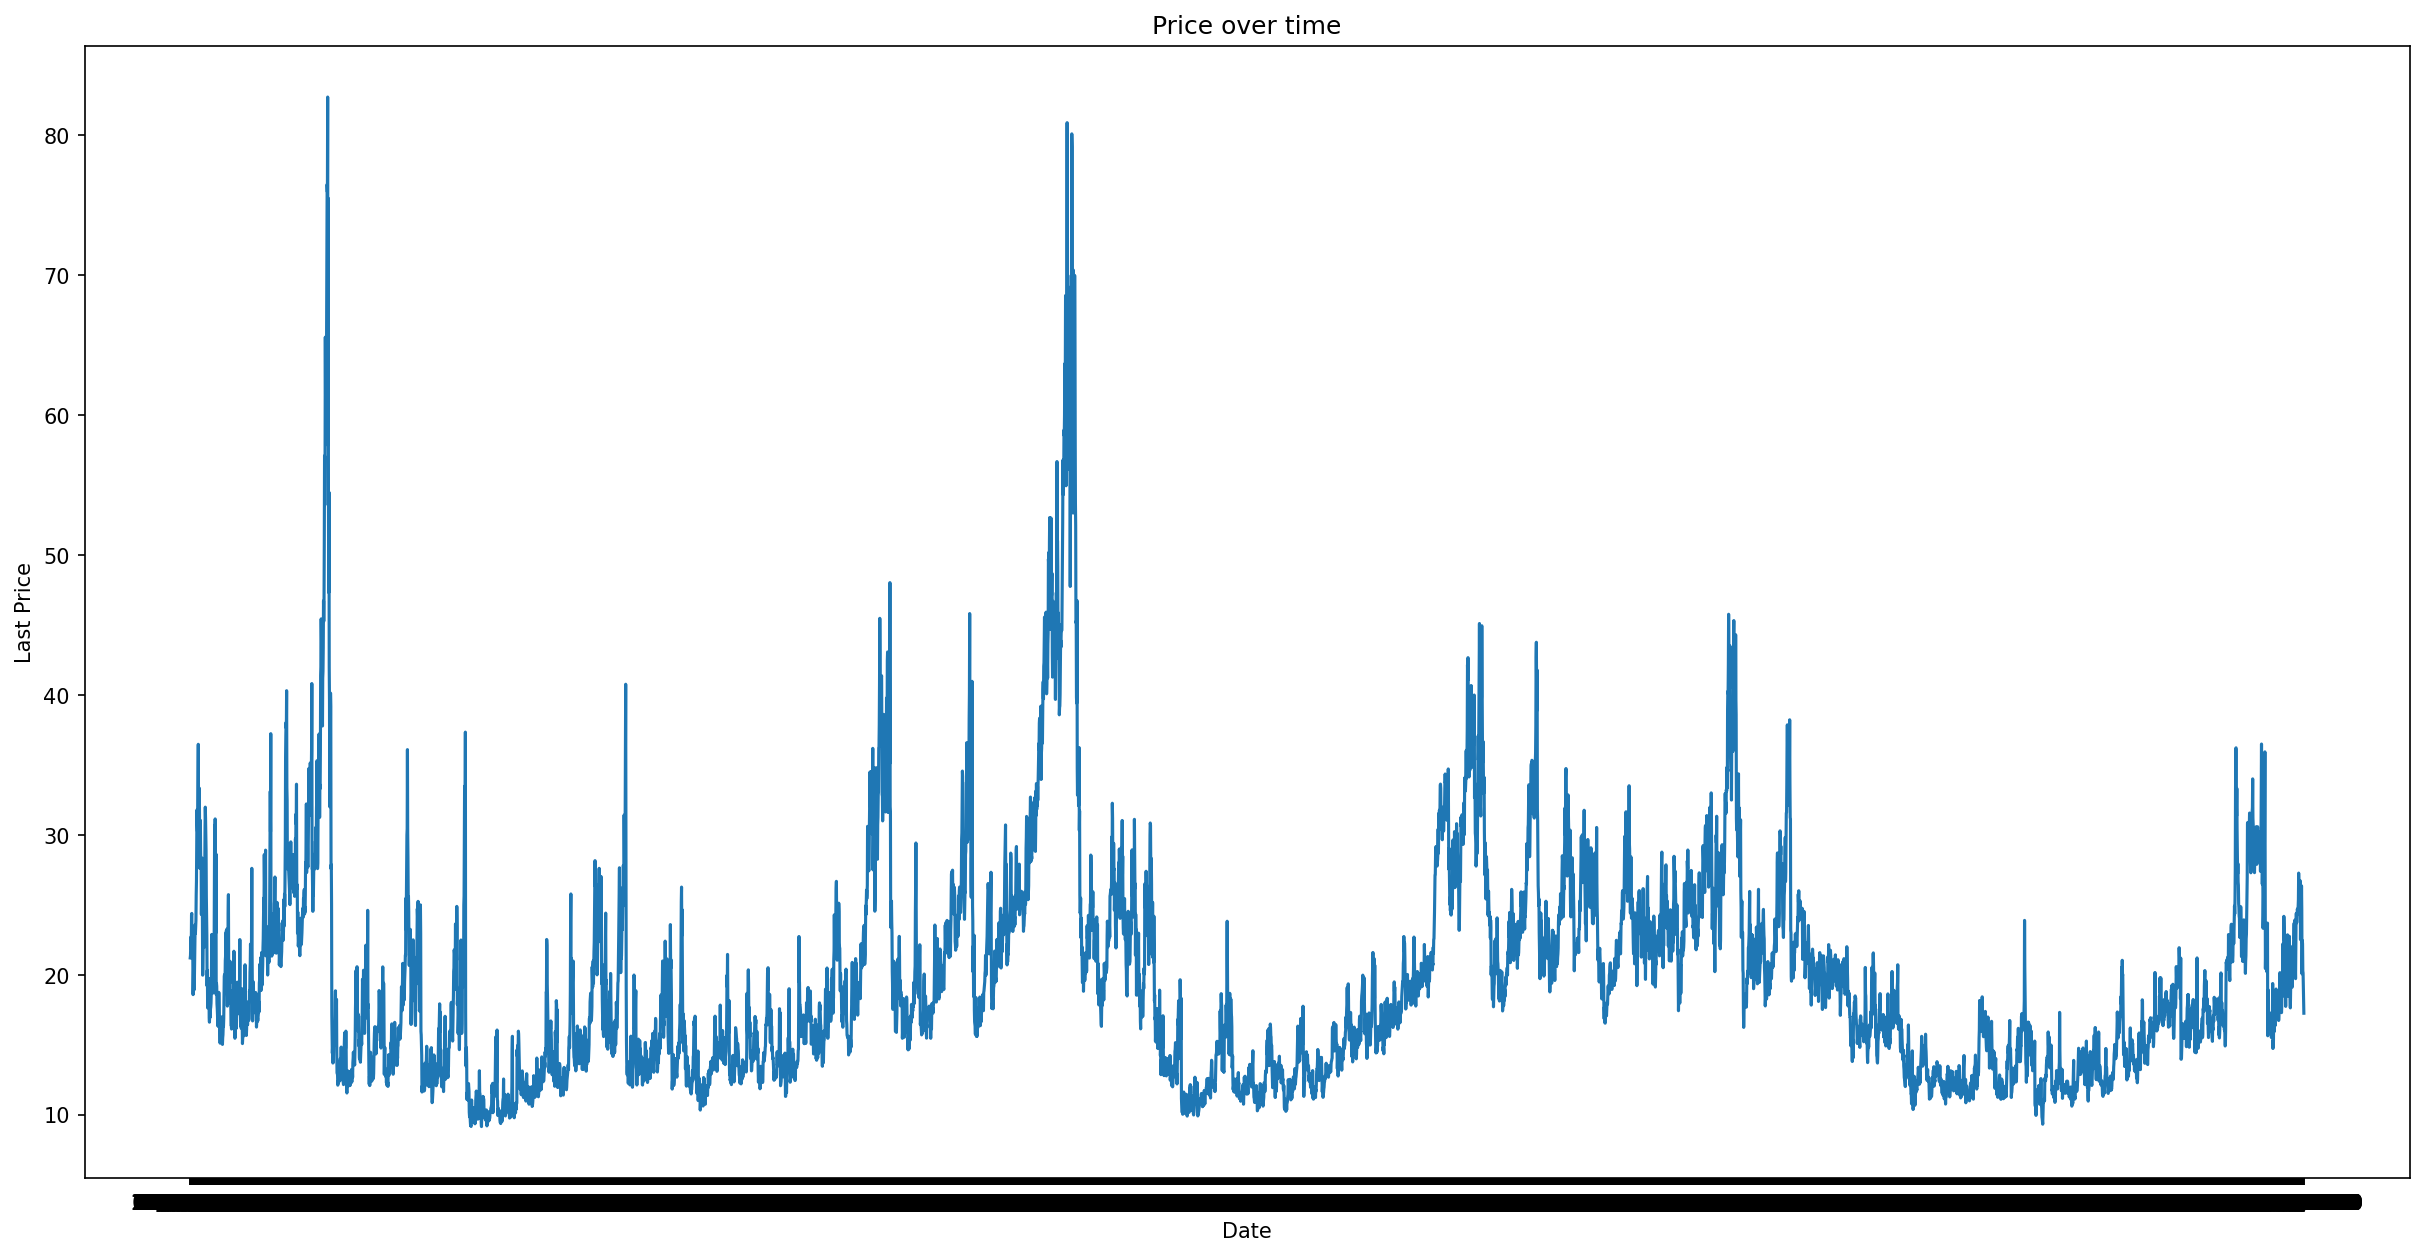

In [23]:
plt.figure(figsize=(20, 10), dpi=150)
plt.plot(VIX_daily['Date'], VIX_daily['Last Price'], color='tab:blue')
plt.gca().set(title='Price over time', 
xlabel='Date', ylabel='Last Price')
plt.show()

In [24]:
#Determine rolling statistics
rolmean = VIX_daily['Last Price'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = VIX_daily['Last Price'].rolling(window=12).std()
print(rolmean,rolstd)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
8131    23.544167
8132    23.160000
8133    22.536667
8134    22.177500
8135    21.585833
Name: Last Price, Length: 8136, dtype: float64 0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
8131    2.108155
8132    2.286868
8133    2.253419
8134    2.579659
8135    2.839697
Name: Last Price, Length: 8136, dtype: float64


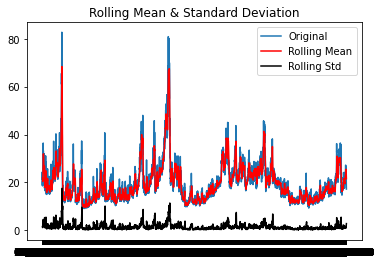

In [25]:
#Plot rolling statistics
import matplotlib.pyplot as plt
import numpy as np
orig = plt.plot(VIX_daily['Date'], VIX_daily['Last Price'], color='tab:blue', label= 'Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

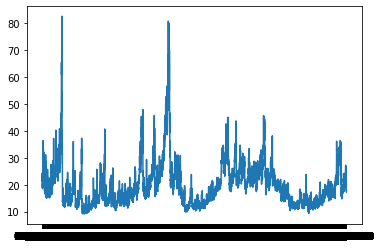

In [26]:
#Plot rolling statistics
orig = plt.plot(VIX_daily['Date'], VIX_daily['Last Price'], color='tab:blue')

In [27]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(VIX_daily['Last Price'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -6.711864e+00
p-value                        3.663477e-09
#Lags Used                     1.000000e+01
Number of Observations Used    8.125000e+03
Critical Value (1%)           -3.431155e+00
Critical Value (5%)           -2.861896e+00
Critical Value (10%)          -2.566959e+00
dtype: float64


p-value is the probability. should be smaller than 0.05. 

In [28]:
#Estimating trend

Dataset_logScale = np.log(VIX_daily['Last Price'])
Dataset_logScale = Dataset_logScale.dropna()
Dataset_logScale

0       3.053529
1       3.061988
2       3.098740
3       3.122365
4       3.082827
          ...   
8131    3.008648
8132    3.001217
8133    2.955951
8134    2.900872
8135    2.847232
Name: Last Price, Length: 8136, dtype: float64

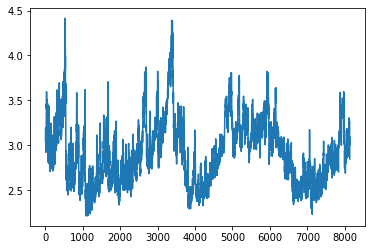

In [29]:
Dataset_logScale.plot()

In [30]:
#Log difference
Dataset_Return= df['Last Price'].pct_change()
Dataset_Return = Dataset_Return.dropna()
Dataset_Return

1        0.008495
2        0.037436
3        0.023906
4       -0.038767
5        0.111824
           ...   
12242    0.000000
12243    0.000000
12244    0.000000
12245    0.000000
12246    0.000000
Name: Last Price, Length: 12246, dtype: float64

In [31]:
# copy the data
df_min_max_scaled = Dataset_logScale.copy()

# apply normalization techniques on logged data
for i in df_min_max_scaled:
    df_min_max_scaled  = (df_min_max_scaled  - df_min_max_scaled .min()) / (df_min_max_scaled .max() - df_min_max_scaled .min())

# view normalized data
print(df_min_max_scaled)

0       0.381790
1       0.385631
2       0.402318
3       0.413044
4       0.395092
          ...   
8131    0.361412
8132    0.358038
8133    0.337486
8134    0.312477
8135    0.288122
Name: Last Price, Length: 8136, dtype: float64


In [32]:
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA

auto

## On Normal Data Value

The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.The AIC function is 2K – 2(log-likelihood) = 2*(K - LL). Lower AIC values indicate a better-fit model. 
BIC = ln(n)k - 2l. https://www.roadlesstraveledstore.com/how-do-i-choose-between-aic-and-bic/.
k = number of variables or input features or columns in the model. k is the numner of parameters estimated. 


In [33]:
model = ARIMA(df['Last Price'])  
results_ARIMA = model.fit()  

In [34]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                12247
Model:                          ARIMA   Log Likelihood              -28467.923
Date:                Fri, 20 May 2022   AIC                          56939.845
Time:                        13:16:48   BIC                          56954.671
Sample:                             0   HQIC                         56944.813
                              - 12247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5265      0.121    161.393      0.000      19.289      19.764
sigma2        64.0824      0.601    106.604      0.000      62.904      65.261
===================================================================================
Ljung-Box (L1) (Q):               11731.84   Jarque-Bera (JB):            116706.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             2.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model = ARIMA(Dataset_logScale)  
results_ARIMA = model.fit()  

In [36]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                 8136
Model:                          ARIMA   Log Likelihood               -3008.401
Date:                Fri, 20 May 2022   AIC                           6020.802
Time:                        13:16:59   BIC                           6034.810
Sample:                             0   HQIC                          6025.592
                               - 8136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9054      0.004    678.018      0.000       2.897       2.914
sigma2         0.1227      0.002     63.844      0.000       0.119       0.126
===================================================================================
Ljung-Box (L1) (Q):                7840.47   Jarque-Bera (JB):               658.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model = ARIMA(Dataset_Return)  
results_ARIMA = model.fit()  

In [38]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                12246
Model:                          ARIMA   Log Likelihood               18435.409
Date:                Fri, 20 May 2022   AIC                         -36866.818
Time:                        13:17:19   BIC                         -36851.992
Sample:                             0   HQIC                        -36861.850
                              - 12246                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      2.985      0.003       0.001       0.002
sigma2         0.0029   1.74e-05    165.682      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                  96.22   Jarque-Bera (JB):             25845.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
pip install pmdarima

In [40]:
import pandas as pd
import numpy as np

In [41]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [42]:
adf_test(df_min_max_scaled)

1. ADF :  -5.910609444040219
2. P-Value :  2.644357297212957e-07
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8124
5. Critical Values :
	 1% :  -3.4311551904760065
	 5% :  -2.861895837245016
	 10% :  -2.5669594074059123


In [43]:
adf_test(VIX_daily['Last Price'])

1. ADF :  -6.711863740946838
2. P-Value :  3.663477254210863e-09
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8125
5. Critical Values :
	 1% :  -3.4311550913443045
	 5% :  -2.8618957934417497
	 10% :  -2.566959384088994


In [44]:
adf_test(Dataset_logScale)

1. ADF :  -5.910609444040032
2. P-Value :  2.644357297215499e-07
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8124
5. Critical Values :
	 1% :  -3.4311551904760065
	 5% :  -2.861895837245016
	 10% :  -2.5669594074059123


In [45]:
adf_test(Dataset_Return)

1. ADF :  -23.928622559697843
2. P-Value :  0.0
3. Num Of Lags :  33
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 12212
5. Critical Values :
	 1% :  -3.430885594094518
	 5% :  -2.8617767054517396
	 10% :  -2.5668959932869027


In [46]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [47]:
stepwise_fit = auto_arima(Dataset_logScale, 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8136
Model:               SARIMAX(1, 1, 2)   Log Likelihood               10490.848
Date:                Fri, 20 May 2022   AIC                         -20973.696
Time:                        13:20:02   BIC                         -20945.680
Sample:                             0   HQIC                        -20964.115
                               - 8136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8682      0.016     54.866      0.000       0.837       0.899
ma.L1         -0.9729      0.018    -54.858      0.000      -1.008      -0.938
ma.L2          0.0381      0.009      4.095      0.000       0.020       0.056
sigma2         0.0044   3.78e-05    117.518      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11880.09
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
from statsmodels.tsa.arima_model import ARIMA

In [49]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(df_min_max_scaled,
suppress_warnings=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8136
Model:               SARIMAX(1, 1, 3)   Log Likelihood               16918.264
Date:                Fri, 20 May 2022   AIC                         -33826.528
Time:                        13:23:11   BIC                         -33791.508
Sample:                             0   HQIC                        -33814.551
                               - 8136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9496      0.006    152.762      0.000       0.937       0.962
ma.L1         -1.0554      0.010   -106.353      0.000      -1.075      -1.036
ma.L2          0.0293      0.011      2.754      0.006       0.008       0.050
ma.L3          0.0408      0.008      4.886      0.000       0.024       0.057
sigma2         0.0009   7.94e-06    115.182      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11548.39
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX - ACCOUNTS FOR DATA SEASONALITY

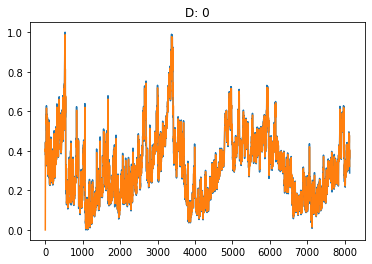

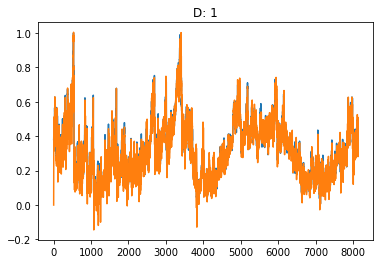

In [50]:
import statsmodels.api



for cd in range(2):

    m = statsmodels.api.tsa.statespace.SARIMAX(
                                                    endog = df_min_max_scaled,
                                                    order = (1,1,1),
                                                    seasonal_order = (0,cd,0,12),
                                                    trend = 'n'
                                               ).fit()


    plt.plot(df_min_max_scaled)
    plt.plot(m.fittedvalues)
    plt.title('D: ' + str(cd))
    plt.show()

In [51]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Last Price   No. Observations:                 8136
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               14309.273
Date:                             Fri, 20 May 2022   AIC                         -28612.546
Time:                                     13:23:39   BIC                         -28591.539
Sample:                                          0   HQIC                        -28605.361
                                            - 8136                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8555      0.004    227.360      0.000       0.848       0.863
ma.L1         -1.0000      0.151     -6.620      0.000      -1.296      -0.704
sigma2         0.0017      0.000      6.562      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3468.50
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
from statsmodels.tsa.arima_model import ARIMA
print(df_min_max_scaled.shape)
train=df_min_max_scaled.iloc[:-30]
test=df_min_max_scaled.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(8136,)
(8106,) (30,)
0.44546207851647696 0.2881224334745227


In [53]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train,order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                 8106
Model:                 ARIMA(1, 0, 5)   Log Likelihood               16858.285
Date:                Fri, 20 May 2022   AIC                         -33700.571
Time:                        13:24:20   BIC                         -33644.568
Sample:                             0   HQIC                        -33681.415
                               - 8106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3152      0.026     12.163      0.000       0.264       0.366
ar.L1          0.9897      0.001    670.901      0.000       0.987       0.993
ma.L1         -0.0955      0.007    -12.910      0.000      -0.110      -0.081
ma.L2         -0.0628      0.008     -7.972      0.000      -0.078      -0.047
ma.L3         -0.0397      0.009     -4.666      0.000      -0.056      -0.023
ma.L4         -0.0475      0.009     -5.389      0.000      -0.065      -0.030
ma.L5         -0.0220      0.008     -2.602      0.009      -0.039      -0.005
sigma2         0.0009   8.13e-06    112.342      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11602.49
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
data = model.fittedvalues

data

0       0.315159
1       0.380511
2       0.384087
3       0.399271
4       0.409386
          ...   
8101    0.431740
8102    0.413379
8103    0.376839
8104    0.353521
8105    0.398110
Length: 8106, dtype: float64

Text(0.5, 1.0, 'RSS: nan')

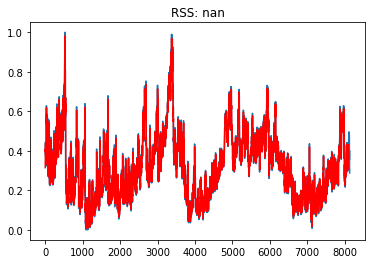

In [55]:
plt.plot(df_min_max_scaled)
plt.plot(model.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((model.fittedvalues-df_min_max_scaled)**2))

In [56]:
predictions_ARIMA_diff = pd.Series(model.fittedvalues)
print (predictions_ARIMA_diff)

0       0.315159
1       0.380511
2       0.384087
3       0.399271
4       0.409386
          ...   
8101    0.431740
8102    0.413379
8103    0.376839
8104    0.353521
8105    0.398110
Length: 8106, dtype: float64


In [57]:
#Convert to cumulative sum

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum)

0          0.315159
1          0.695670
2          1.079758
3          1.479029
4          1.888415
           ...     
8101    2544.710788
8102    2545.124167
8103    2545.501006
8104    2545.854528
8105    2546.252638
Length: 8106, dtype: float64


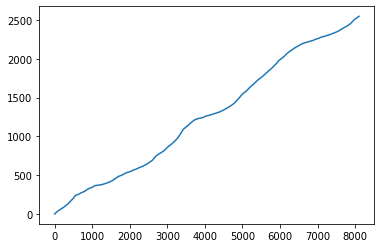

In [58]:
predictions_ARIMA_log = pd.Series(df_min_max_scaled, index=df_min_max_scaled.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)
predictions_ARIMA_log.plot()

In [59]:
start=len(train) 
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start=start,end=end)
pred=model.predict(start=start,end=end ).rename('ARIMA predictions')

In [60]:
pred.head()

8106    0.429635
8107    0.426594
8108    0.422442
8109    0.418618
8110    0.416765
Name: ARIMA predictions, dtype: float64

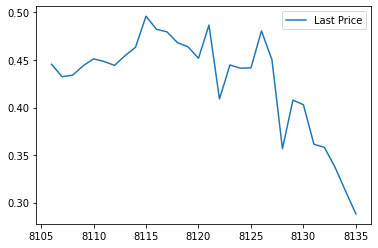

In [61]:
test.plot(legend=True)

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test))
mse = metrics.mean_squared_error(pred, test)
print(rmse)
print (mse)

0.05168351378326319
0.002671185596984756


LSTM

In [63]:
final_data = pd.DataFrame(data, columns=['Price'])

In [64]:
final_data

,Price
0,0.315159
1,0.380511
2,0.384087
3,0.399271
4,0.409386
...,...
8101,0.431740
8102,0.413379
8103,0.376839
8104,0.353521


In [65]:
# split into train and test sets
train_set = int(len(final_data) * 0.7)
test_set = len(final_data) - train_set
train = final_data[test_set:len(final_data)]
test = final_data[train_set:len(final_data)]
print(len(train), len(test))

5674 2432


In [66]:
train.values

array([[0.23005943],
       [0.20045253],
       [0.18270798],
       ...,
       [0.37683929],
       [0.35352126],
       [0.39811032]])

In [67]:
test.shape

(2432, 1)

In [68]:
print(index_future_dates)

DatetimeIndex(['1970-01-01 00:00:00.000008106'], dtype='datetime64[ns]', freq='D')


In [69]:
VIX_daily.shape[0]

8136

In [70]:
import sklearn
from sklearn.model_selection import train_test_split

training_set = df.iloc[:, 1:2].values
X_train = []
y_train = []

for i in range(100, VIX_daily.shape[0]):
    X_train.append(training_set[i-100:i,0])
    y_train.append(training_set[i,0])
    if i<=101:
     print(X_train)
     print(y_train)
     print()

[array([21.19, 21.37, 22.17, 22.7 , 21.82, 24.26, 24.37, 21.16, 21.55,
       22.1 , 21.03, 18.57, 19.63, 20.56, 19.33, 18.9 , 19.63, 20.81,
       21.67, 23.57, 22.94, 23.53, 23.87, 25.67, 26.67, 29.83, 31.77,
       30.75, 30.23, 32.45, 35.13, 36.45, 31.98, 30.48, 30.74, 33.32,
       30.15, 27.59, 30.32, 31.02, 28.81, 27.75, 28.11, 24.29, 25.7 ,
       28.33, 27.36, 23.91, 19.96, 21.44, 22.86, 23.22, 24.35, 22.09,
       21.96, 24.83, 27.66, 30.49, 31.96, 31.16, 29.9 , 28.85, 25.59,
       23.85, 22.79, 19.19, 20.31, 17.62, 18.41, 19.4 , 18.76, 19.61,
       19.73, 16.91, 16.6 , 17.22, 17.33, 16.95, 17.54, 17.68, 17.96,
       18.63, 21.01, 22.87, 21.57, 20.57, 19.29, 21.89, 20.31, 18.69,
       21.58, 19.9 , 21.89, 27.18, 30.67, 27.95, 31.12, 27.19, 22.96,
       28.62])]
[18.58]

[array([21.19, 21.37, 22.17, 22.7 , 21.82, 24.26, 24.37, 21.16, 21.55,
       22.1 , 21.03, 18.57, 19.63, 20.56, 19.33, 18.9 , 19.63, 20.81,
       21.67, 23.57, 22.94, 23.53, 23.87, 25.67, 26.67, 29.83, 

In [71]:
len(y_train), len(X_train)

(8036, 8036)

In [72]:
test_set = df.iloc[:, 1:2].values
X_test = []
y_test = []

for i in range(100, VIX_daily.shape[0]):
    X_test.append(test_set[i-100:i,0])
    y_test.append(test_set[i,0])
    if i<=100:
     print(X_test)
     print(y_test)
     print()

[array([21.19, 21.37, 22.17, 22.7 , 21.82, 24.26, 24.37, 21.16, 21.55,
       22.1 , 21.03, 18.57, 19.63, 20.56, 19.33, 18.9 , 19.63, 20.81,
       21.67, 23.57, 22.94, 23.53, 23.87, 25.67, 26.67, 29.83, 31.77,
       30.75, 30.23, 32.45, 35.13, 36.45, 31.98, 30.48, 30.74, 33.32,
       30.15, 27.59, 30.32, 31.02, 28.81, 27.75, 28.11, 24.29, 25.7 ,
       28.33, 27.36, 23.91, 19.96, 21.44, 22.86, 23.22, 24.35, 22.09,
       21.96, 24.83, 27.66, 30.49, 31.96, 31.16, 29.9 , 28.85, 25.59,
       23.85, 22.79, 19.19, 20.31, 17.62, 18.41, 19.4 , 18.76, 19.61,
       19.73, 16.91, 16.6 , 17.22, 17.33, 16.95, 17.54, 17.68, 17.96,
       18.63, 21.01, 22.87, 21.57, 20.57, 19.29, 21.89, 20.31, 18.69,
       21.58, 19.9 , 21.89, 27.18, 30.67, 27.95, 31.12, 27.19, 22.96,
       28.62])]
[18.58]



In [73]:
len(y_test), len(X_test)

(8036, 8036)

In [74]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [102]:
#Reshape the data
#X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
#X_train.shape

(8036, 100, 1)

In [75]:
X_train, y_train

(array([[21.19, 21.37, 22.17, ..., 27.19, 22.96, 28.62],
        [21.37, 22.17, 22.7 , ..., 22.96, 28.62, 18.58],
        [22.17, 22.7 , 21.82, ..., 28.62, 18.58, 19.38],
        ...,
        [18.75, 17.32, 17.7 , ..., 22.2 , 20.26, 20.11],
        [17.32, 17.7 , 17.18, ..., 20.26, 20.11, 19.22],
        [17.7 , 17.18, 17.84, ..., 20.11, 19.22, 18.19]]),
 array([18.58, 19.38, 19.17, ..., 19.22, 18.19, 17.24]))

In [76]:
X_train.shape, X_train.size

((8036, 100), 803600)

In [77]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

8036/8036 - 113s - loss: 103.5205 - 113s/epoch - 14ms/step


In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [79]:
# make predictions
Predict = model.predict(test)

In [80]:
import math
# calculate root mean squared error
Score = math.sqrt(mean_squared_error(test, Predict))
print('Train Score: %.2f RMSE' % (Score))

Train Score: 9.34 RMSE


In [81]:
print('MAPE:',mean_absolute_percentage_error(test, Predict))

MAPE: 41.139566830681076


In [82]:
print('MAE:', MAE(test, Predict))

MAE: 9.343358097564254


RF

In [83]:
rf= RandomForestRegressor(n_estimators=30, verbose=2, random_state=42, n_jobs = -1)

In [84]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

In [85]:
#X_train, X_train.shape

In [86]:
#y_train, y_train.shape

In [124]:
#Reshape the data
#dimX1, dimX2, dimX3 = np.array(X_train).shape
#X_train = np.reshape(np.array(X_train), (dimX1*dimX3, dimX2))
#X_train = X_train.reshape(X_train.shape[1:])
#X_train = X_train.transpose()
#X_train.shape

ValueError: ignored

In [118]:
#X_train

array([[21.19, 21.37, 22.17, ..., 27.19, 22.96, 28.62],
       [21.37, 22.17, 22.7 , ..., 22.96, 28.62, 18.58],
       [22.17, 22.7 , 21.82, ..., 28.62, 18.58, 19.38],
       ...,
       [18.75, 17.32, 17.7 , ..., 22.2 , 20.26, 20.11],
       [17.32, 17.7 , 17.18, ..., 20.26, 20.11, 19.22],
       [17.7 , 17.18, 17.84, ..., 20.11, 19.22, 18.19]])

In [120]:
#X_train = X_train.reshape(X_train.shape[1:])
#X_train = X_train.transpose()

In [121]:
#X_train

array([[21.19, 21.37, 22.17, ..., 18.75, 17.32, 17.7 ],
       [21.37, 22.17, 22.7 , ..., 17.32, 17.7 , 17.18],
       [22.17, 22.7 , 21.82, ..., 17.7 , 17.18, 17.84],
       ...,
       [27.19, 22.96, 28.62, ..., 22.2 , 20.26, 20.11],
       [22.96, 28.62, 18.58, ..., 20.26, 20.11, 19.22],
       [28.62, 18.58, 19.38, ..., 20.11, 19.22, 18.19]])

In [94]:

#dimy1, dimy2, dimy3 = np.array(y_train).shape
#y_train = np.reshape(np.array(y_train),  (dimy1*dimy2, dimy3 ))

ValueError: ignored

In [122]:
#print(X_train.shape, y_train.shape)

(100, 8036) (8036,)


In [87]:
rf = rf.fit(X_train, y_train)

building tree 1 of 30
building tree 2 of 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


In [88]:
rf.score(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


0.9937273814182833

In [89]:
rf.score(X_test[:2332], y_test[:2332])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


0.9907167266101522

In [90]:
predicted= rf.predict(X_test)

predicted

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


array([22.36133333, 19.43066667, 19.20366667, ..., 19.548     ,
       19.03      , 17.651     ])

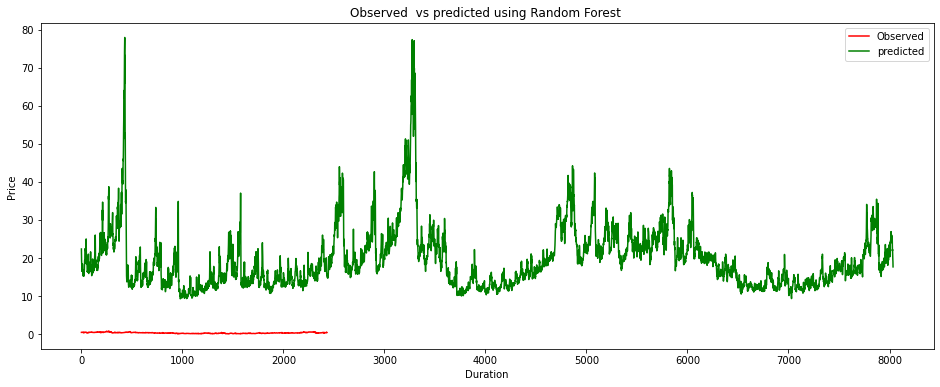

In [91]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(test.values, color = 'red', label = 'Observed')
plt.plot(predicted, color = 'green', label = 'predicted')
plt.title('Observed  vs predicted using Random Forest ')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.legend()
plt.show()

SVM

In [92]:
svr_linear = SVR(kernel='linear',C=0.5, gamma=5, epsilon=0.01)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
SVM = GridSearchCV(svr_linear, parameters)

In [ ]:
SVM.fit(X_train,y_train).predict(X_train)

In [ ]:
SVM.score(X_train, y_train)

In [ ]:
SVm.score(X_test[:2332], y_test[:2332])

In [ ]:
predicted_SVM = clf1.predict(X_train)

In [ ]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(train.values, color = 'red', label = 'Observed')
plt.plot(predicted_SVM, color = 'green', label = 'predicted')
plt.title('Observed  vs predicted using SVM ')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.legend()
plt.show()

SVM Model with RBF Kernel

In [ ]:
# SVM Model with RBF Kernel 
clf = SVR(kernel='rbf') 
clf.fit(X_train, y_train) 

In [ ]:
y_pred = clf.predict(X_test)

print('Accuracy Score: {:.4f}'.format(clf.score(X_train, y_train)))

CNN as descriminator

In [ ]:
x_train =  X_train.reshape(len(X_train), 10*10).astype('float32') 
x_test =  X_test.reshape(len(X_test), 10*10).astype('float32') 

In [ ]:
x_train /= 255
x_test /= 255

In [ ]:
# Data is currently flattened, we need to reshape it back to 10 * 10. To do that we reshape the data.

x_train = np.reshape(x_train, [-1, 10, 10])

x_test = np.reshape(x_test, [-1, 10, 10])

In [ ]:
# model_2 requires input of 32 X 32. So we will pad the train and test images with zeros to increase the size to 32 X 32.

x_train=np.pad(x_train, ((0,0), (11,11), (11, 11)), 'constant')

x_test=np.pad(x_test, ((0,0), (11,11), (11, 11)), 'constant')

In [ ]:
x_train.shape

x_test.shape

In [ ]:
# Convolutional model requires input to be of 3 dimensions. We will add a channel dimension to it.

x_train = np.reshape(x_train, [-1, 32, 32, 1])

x_test = np.reshape(x_test, [-1, 32, 32, 1])

In [ ]:
# convert class labels to one-hot vectors
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)

In [ ]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(32,32,1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
# fit model

batch_size = 128  # mini-batch with 128 examples
epochs = 30
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

In [ ]:
yhat = model.predict(x_test, verbose=1)

In [ ]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    
plot_loss_accuracy(history)

In [ ]:
# calculate root mean squared error
Score = math.sqrt(mean_squared_error(final_data[:8006], yhat))
print('Train Score: %.2f RMSE' % (Score))

In [ ]:
print('MAPE:',mean_absolute_percentage_error(final_data[:8006], yhat))

In [ ]:
print('MAE:', MAE(final_data[:8006], yhat))

In [ ]:
## We will use Keras evaluate function to evaluate performance on the test set

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)